In [1]:
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import gc
from PIL import ImageFile
import torch
import open_clip
from PIL import Image
import concurrent
import pandas as pd


ImageFile.LOAD_TRUNCATED_IMAGES = True
torch.set_grad_enabled(False)

/Users/fugazi/Fashion/sd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
FILENAMES_DF_PATH = 'assets-224-filename-kaggle.csv'
filename_df = pd.read_csv(FILENAMES_DF_PATH)
filename_df.head()

In [5]:
def get_file_path_from_url(url):
    return '-'.join(url.split('/')[5:])

products_df = pd.read_csv('products.csv')
products_df['filename'] = products_df['searchImage'].apply(get_file_path_from_url)
products_df = products_df.drop(columns=['Unnamed: 0'])

final_df = pd.merge(filename_df, products_df, left_on='0', right_on='filename', how='left').drop_duplicates(subset='filename', keep='first').reset_index(True)


In [6]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
tokenizer = open_clip.get_tokenizer('ViT-B-32')

In [304]:
image_to_search = Image.open('image-to-search.jpeg')

In [305]:
encoding = model.encode_image(preprocess(image_to_search).unsqueeze(0))

In [316]:
tokenizer('parachute pants with pleats')

torch.Size([1, 77])

In [33]:
image_embeddings = torch.load('image_embeddings_kaggle.pt', map_location=torch.device('cpu'))
image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True)

In [303]:
def plotKNN(base_embedding, nrow=5, ncol=5, figsize=(10, 10), title=""):
    less_than_1000_indices = final_df[final_df['price'] <= 1000].index.tolist()
    probs = torch.nn.functional.cosine_similarity(image_embeddings[less_than_1000_indices], base_embedding.view(1, 512))

    top_ids = probs.topk(nrow * ncol).indices
    top_indices = torch.tensor([less_than_1000_indices[i] for i in top_ids])
    products = final_df.loc[top_indices.tolist()].to_dict('records')
    top_scores = probs[top_ids]
    assert len(products) == len(top_indices.tolist())


    fig, axs = plt.subplots(nrow, ncol, figsize=(20, 20))
    fig.suptitle(f"{title}", fontsize=20, fontname='Comic Sans MS')
    
    for i, (product, score, ix) in enumerate(zip(products, top_scores, top_indices)):
        # print('product: ', product)
        img_path = 'assets/' + product['filename']
        image = Image.open(img_path)
        axs[i//ncol][i%ncol].imshow(image)
        axs[i//ncol][i%ncol].set_title(f"{int(score * 100)/100}, {ix}, {product['price']}")

        axs[i//ncol][i%ncol].axis('off')

    plt.show()
    for ix in top_indices.tolist():
        url = 'https://www.myntra.com/' + final_df.iloc[ix]['landingPageUrl']
        print(f'{ix} : {url}')

def mashup(image_ixs, nrow=5, ncol=5, figsize=(10, 10)):
    mean_embedding = image_embeddings[torch.tensor(image_ixs)].mean(dim=0)
    mean_embedding /= mean_embedding.norm()

    plotKNN(mean_embedding, nrow, ncol, figsize, title='Mashup :' + str(image_ixs))

def ask(query, nrow=5, ncol=5, figsize=(10, 10)):
    text = tokenizer([query])
    text_features = model.encode_text(text)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    plotKNN(text_features, nrow, ncol, figsize, title=query)

def similar(image_ix, nrow=5, ncol=5, figsize=(10, 10)):
    base_image_feature = image_embeddings[image_ix]
    base_image_feature /= base_image_feature.norm()
    plotKNN(base_image_feature, nrow, ncol, figsize, title=f'Similar: {image_ix}')

def mashup_all(image_ixs, query, nrow=5, ncol=5, figsize=(20, 20), alpha=0.5):
    image_mean_embedding = image_embeddings[torch.tensor(image_ixs)].mean(dim=0)
    image_mean_embedding /= image_mean_embedding.norm()

    query_embedding = model.encode_text(tokenizer([query]))
    query_embedding /= query_embedding.norm(dim=-1, keepdim=True)

    final_embedding = alpha * image_mean_embedding + (1 - alpha) * query_embedding.squeeze()
    final_embedding /= final_embedding.norm(dim=0)
    plotKNN(final_embedding, nrow, ncol, figsize, title='Mashup: ' + str(image_ixs) + ', ' + query)


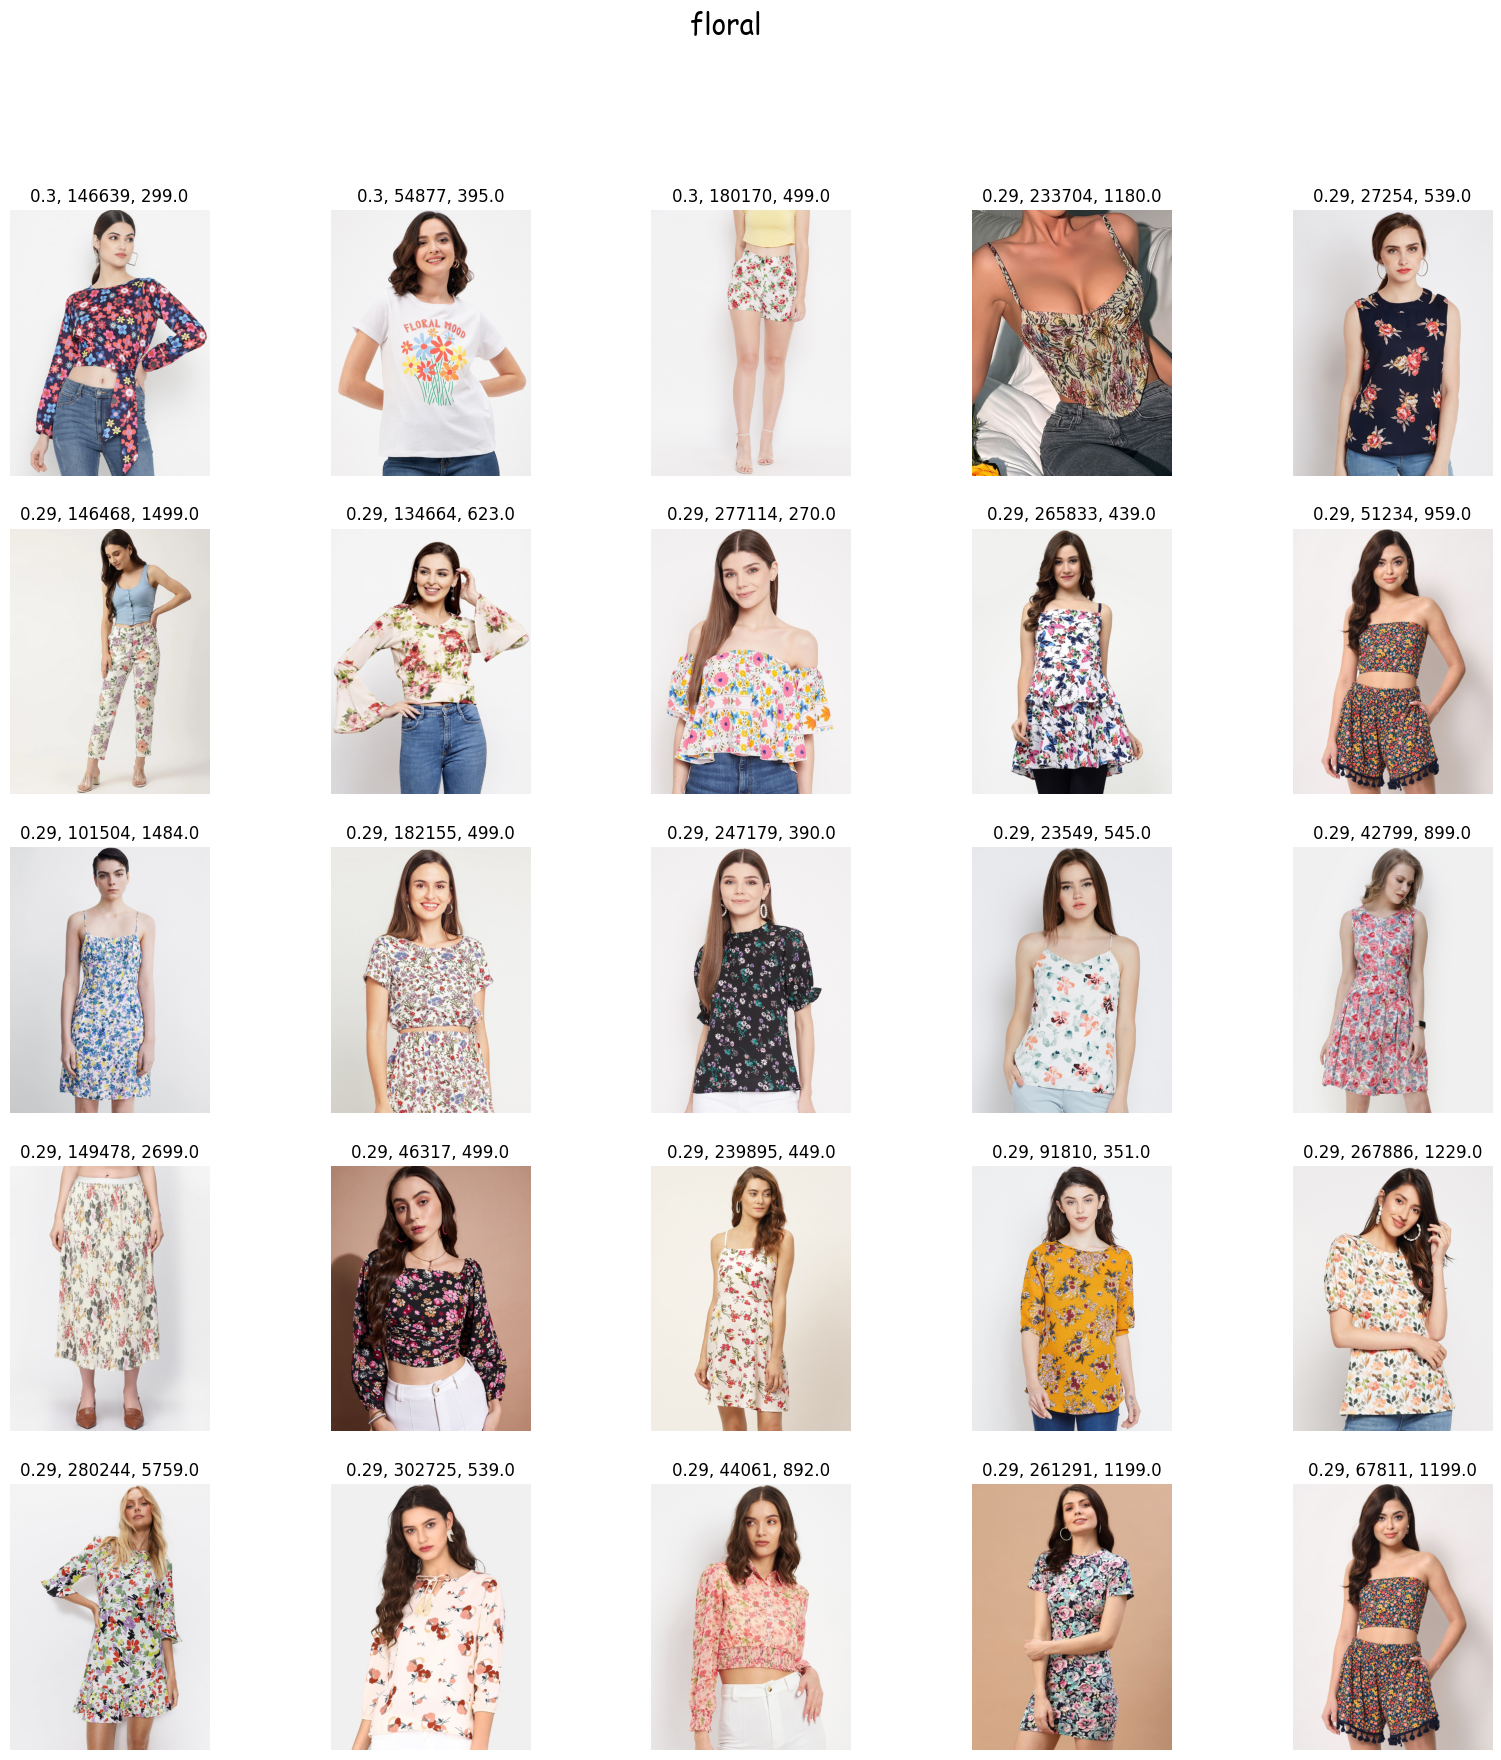

146639 : https://www.myntra.com/tops/kannan/kannan-black-floral-print-crepe-crop-top/18155108/buy
54877 : https://www.myntra.com/tshirts/mast+%26+harbour/mast--harbour-white-floral-printed-pure-cotton-t-shirt/23345018/buy
180170 : https://www.myntra.com/shorts/belle-fille/belle-fille-women-white--red-floral-print-regular-shorts/10261913/buy
233704 : https://www.myntra.com/tops/lulu+%26+sky/lulu--sky-tropical-printed-crochet-style-top/25017762/buy
27254 : https://www.myntra.com/tops/rare/rare-women-navy-blue-printed-top/2127365/buy
146468 : https://www.myntra.com/trousers/marks+%26+spencer/marks--spencer-women-cream-coloured-floral-printed-trousers/20566460/buy
134664 : https://www.myntra.com/tops/claura/claura-cream-coloured--red-floral-print-georgette-crop-top/19517204/buy
277114 : https://www.myntra.com/tops/berrylush/berrylush-white--pink-floral-off-shoulder-crepe-bardot-crop-top/14319256/buy
265833 : https://www.myntra.com/tops/miss+ayse/miss-ayse-printed-crepe-tiered-top/21569024/

In [239]:
# ask('parachute pants')    
ask('floral')
# similar(78481) 
# mashup_all([105301], 'short length bolero shrug', alpha=0.)

In [186]:
%%time
def get_probs(query):
    text = tokenizer([query])
    text_features = model.encode_text(text)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    return torch.nn.functional.cosine_similarity(image_embeddings, text_features.view(1, 512))

def plot_probs(queries):
    n = int(len(queries) ** 0.5)
    m = (len(queries) + n - 1) // n
    fig, axs = plt.subplots(n, m, figsize=(10, 10))
    for i, query in enumerate(queries):
        probs = get_probs(query)
        axs[i//m][i%m].hist(probs.tolist(), bins=500, range=(-0.1, 0.4))
        axs[i//m][i%m].set_title(query)
    plt.show()


CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 8.11 µs


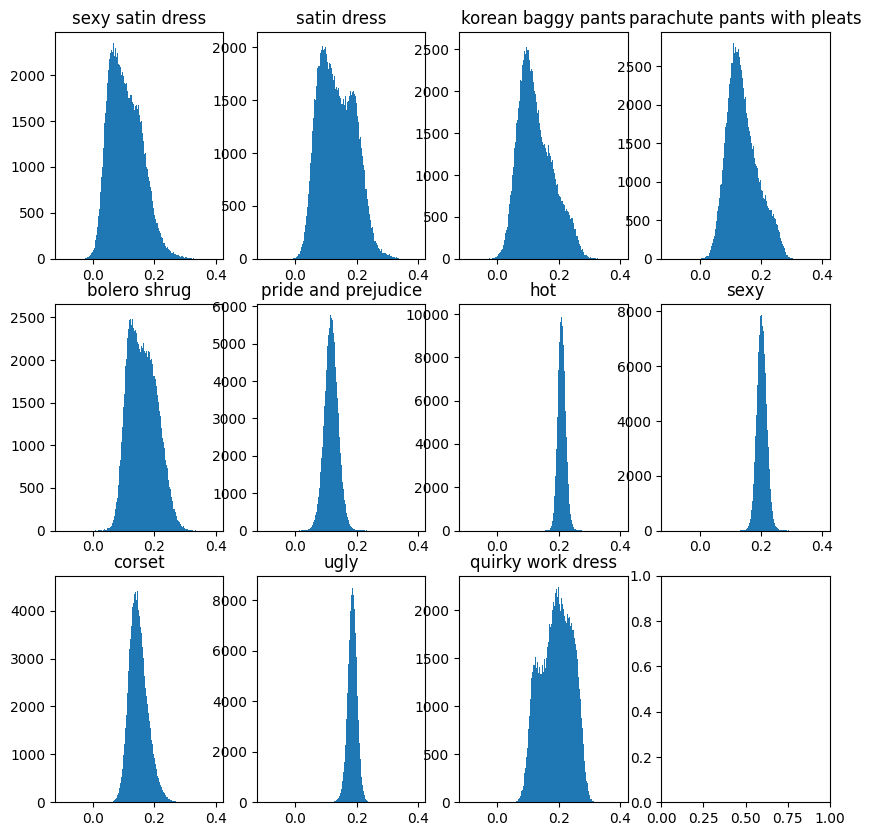

In [187]:
queries = ['sexy satin dress',
'satin dress',
'korean baggy pants',
'parachute pants with pleats',
'bolero shrug',
'pride and prejudice',
'hot', 
'sexy',
'corset',
'ugly',
'quirky work dress',
]

plot_probs(queries)